In [1]:
import os
os.chdir('..\\') # in ./tests folder - so changing to parent folder for imports

from consts import FOLDER2FLOW_RESULTS
import pandas as pd
import pprint
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

class df_extra:    
    def __init__(self, df):
        self.df = df
        self.num_rows = df.shape[0]
        self.data_dict = {}

    def add_data_to_df(self, col_name, data):
        self.data_dict[col_name] = [data]*self.num_rows
        self.df[col_name] = data

def create_united_df(date_folder, timelimit=600): # This is a df of all networks in folder
    res_dp = os.path.join(FOLDER2FLOW_RESULTS, date_folder)
    dfs_list = []
    for network in sorted(os.listdir(res_dp), reverse=True):
        df_fp = os.path.join(res_dp, network, "results.df")
        if network.endswith(".log") or not os.path.exists(df_fp):
            continue
        df = pd.read_pickle(df_fp)

        _df_extra = df_extra(df)
        _df_extra.add_data_to_df("network", network)
        _df_extra.add_data_to_df("mu", network.split("_")[1])

        dfs_list.append(df)
    df = pd.concat(dfs_list)
    df.reset_index(inplace=True)
    del df["index"]
    
    # replace names to shorter names for readabilty
    df["algo"].replace(f"NLP-100-TL-{timelimit}", "NLP100", inplace=True)
    df["algo"].replace(f"NLP-150-TL-{timelimit}", "NLP150", inplace=True)
    df["algo"].replace(f"NLP-200-TL-{timelimit}", "NLP200", inplace=True)
    
    df["algo"].replace(f"LLP-100", "LLP100", inplace=True)
    df["algo"].replace(f"louvain-ILP-num_com_bound 150", "LLP150", inplace=True)
    df["algo"].replace(f"louvain-ILP-num_com_bound 200", "LLP200", inplace=True)
    
    return df

def prepare_data_for_plot_per_mu(df):
    evals = ["avg_modularity", "std_modularity", "avg_jaccard", "std_jaccard"]
    mus = ["all", "0.4", "0.5", "0.6"]
    evals_dict = {}

    for mu in mus:
        evals_dict[mu] = {}
        for _eval in evals:
            evals_dict[mu][_eval] = {}

    for algo in df.algo.unique():
        for mu, evals in evals_dict.items():
    #         print(algo, mu)
            if mu == "all":
                algo_rows = df.loc[df["algo"]==algo]
            else:
                algo_rows = df.loc[df["algo"]==algo].loc[df["mu"]==mu]

            avg_modularity = algo_rows["modularity - algo"].mean()
            std_modularity = algo_rows["modularity - algo"].std()
            avg_jaccard = algo_rows["jaccard"].mean()
            std_jaccard = algo_rows["jaccard"].std()

            evals["avg_modularity"][algo] = avg_modularity
            evals["std_modularity"][algo] = std_modularity
            evals["avg_jaccard"][algo] = avg_jaccard
            evals["std_jaccard"][algo] = std_jaccard
    return evals_dict

def prepare_data_for_plot_per_eval(df):
    evals_dict = {}
    evals = ["avg_modularity", "std_modularity", "avg_jaccard", "std_jaccard"]
    mus = ["0.4", "0.5", "0.6"]
    for _eval in evals:
        evals_dict[_eval] = {}
        for mu in mus:
            evals_dict[_eval][mu] = df.loc
    

def create_plots(data_for_plot):
    for mu, mu_evals in data_for_plot.items():
        for eval_name, eval_data in mu_evals.items():
            fig, ax = plt.subplots()
            ax.set_title(f'{eval_name}, mu={mu}')
            x = eval_data.values()
            y = eval_data.keys()
            ax.plot(y, x)
#             ax.axhline(y=list(x)[0], color='r', linestyle='--')

def run_visu(date_folder):
    df = create_united_df(date_folder)
    display(df)
    data_for_plots = prepare_data_for_plot_per_mu(df)
    print(data_for_plots)
    create_plots(data_for_plots)

In [53]:
from collections import defaultdict

def create_plot_all_mus(df, ev_col="modularity - algo", plot_name="avg modularity per mu", num=0):
    mus = ["0.4", "0.5", "0.6"]
    mu_indices = [float(val) for val in mus]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(f'{plot_name}')
    y_dict = defaultdict(list)
    y_std_dict = defaultdict(list)
    for algo in df.algo.unique():
        # avg_modularity
        for mu in mus:
            #algo_rows = df.loc[df["algo"]==algo].loc[df["mu"]==mu].loc[df["num communities - algo"]!=df["number_of_mega_nodes"]]
            algo_rows = df.loc[df["mu"]==mu].loc[df["algo"]==algo]
            if algo != "Louvain":
                algo_rows = algo_rows.loc[df["number_of_mega_nodes"]-df["num communities - algo"]>=num]
            algo_eval_rows = algo_rows[ev_col]
            if algo =="Louvain" or algo == "Newman":
                y_dict[algo].append(algo_eval_rows.mean())
            else:
                y_dict[algo].append(algo_eval_rows.mean())
                y_std_dict[algo].append(algo_eval_rows.std())
    width  = np.min(np.diff(mu_indices))/3
    num_of_algos = len(y_dict.keys())
    for i, algo in enumerate(y_dict.keys()):
        if algo =="Louvain" or algo == "Newman":
            ax.bar(mu_indices + (-1)**i * width/num_of_algos, y_dict[algo], width, label=algo)
        else:
            ax.bar(mu_indices + (-1)**i * width/num_of_algos, y_dict[algo], width, label=algo,yerr=y_std_dict[algo],)
    ax.legend()

        
def create_graph(date_folder, ev_col="modularity - algo", plot_name="avg modularity per mu", num=0):
    df = create_united_df(date_folder)
    #display(df)
    create_plot_all_mus(df, ev_col, plot_name,  num)
    return df

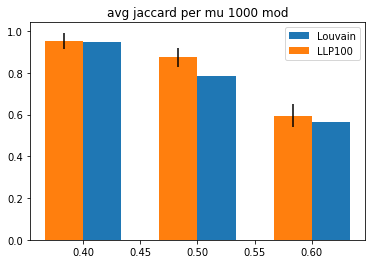

In [54]:
date_1000_nodes_folder = "29-05-2022--21-34-19 1000 mod"

df = create_graph(date_1000_nodes_folder, ev_col="jaccard", plot_name="avg jaccard per mu 1000 mod", num=2)

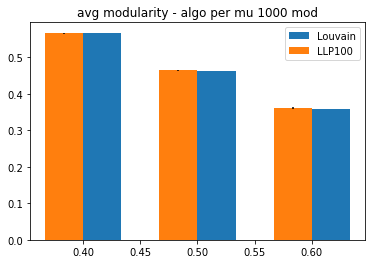

In [55]:
df = create_graph(date_1000_nodes_folder, ev_col="modularity - algo", plot_name="avg modularity - algo per mu 1000 mod", num=2)